In [1]:
import os
import sys
import xarray as xr
import numpy as np
import xesmf as xe
import pandas as pd
from datetime import datetime, timedelta


In [2]:
%matplotlib inline

In [3]:
def denormalize(array,key):
    norm_dict = {'u_wind':[-20,20],
                'v_wind':[-20,20],
                'temp':[210,305],
                'sea_press':[98000,105000],
                'precip':[-7,-2],
                'vapor':[-1,2.]}
    if key == 'wind':
        array = array * 20
    elif key == 'precip':
        array = 10**(array * (norm_dict[key][1] - norm_dict[key][0]) + norm_dict[key][0])
    else:
        array = array * (norm_dict[key][1] - norm_dict[key][0]) + norm_dict[key][0]
    return array

#create netCDF files
def write_netcdf(datas,key,var_dict,lon,lat,start_time,lead_time=None):
    if lead_time is not None:
        data_vars = {
            var_dict[key] : (["time","lead_time","lat","lon"], datas[key]),
        }
        coords = {
            "lon": lon,
            "lat": lat,
            "lead_time": lead_time,
            "time": start_time
        }
    else:
        data_vars = {
            var_dict[key] : (["time","lat","lon"], datas[key]),
        }
        coords = {
            "lon": lon,
            "lat": lat,
            "time": start_time
        }
    ds = xr.Dataset(data_vars = data_vars, coords = coords)
    return ds

In [4]:
in_dir = '/scratch/08589/hvtran/predrnn-pytorch/checkpoints/2018_predrnn_15days/test_result/'
out_dir = '/scratch/08589/hvtran/PredRNN_Sandy/'
start_date = datetime.strptime("2018-09-01-00",'%Y-%m-%d-%H')
#start_date = datetime(2012,10,21,12)

list_batchs = sorted([int(name) for name in os.listdir(in_dir) if os.path.isdir(os.path.join(in_dir, name))])
n_batchs = len(list_batchs)
print(n_batchs)
curr_timestamp = datetime.now().strftime('%Y%m%d%H')

16


In [5]:
step = 12
#data parameters
var_dict = {'u_wind':'u10', 'wind':'v10', 'temp': 't2m', 'sea_press': 'sea_press', 'precip':'tp', 'vapor':'tcwv'}
var_order = {'wind':0, 'sea_press':1, 'precip':2}

lon = np.arange(0,360,0.25)
lat = np.arange(-89.75,90.1,0.25)[::-1]
start_time = pd.date_range(start_date, periods=n_batchs, freq=str(step)+'H')
start_time = np.array([(x - datetime(2001,1,1,0)).total_seconds()/3600. for x in start_time])


In [6]:

gt_final_arr = []
pd_final_arr = []

for batchi in list_batchs:
    print(batchi)
    #print(batchi)
    gt_arr = np.load(in_dir+str(batchi)+'/gt.npy')
    pd_arr = np.load(in_dir+str(batchi)+'/pd.npy')
    #appending
    if batchi < len(list_batchs):
        gt_final_arr.append(gt_arr[:,:step,:,:,:])
    else:
        gt_final_arr.append(gt_arr)
    pd_final_arr.append(pd_arr)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [7]:
gt_final_arr = np.concatenate(gt_final_arr, axis=1)
pd_final_arr = np.concatenate(pd_final_arr, axis=0)
print(gt_final_arr.shape)
print(pd_final_arr.shape)

(1, 240, 720, 1440, 3)
(16, 60, 720, 1440, 3)


In [33]:
var_key = "precip"
lead_time = np.arange(pd_arr.shape[1])*6
start_time = pd.date_range(start_date, periods=n_batchs, freq=str(step*6)+'H')
start_time = np.array([(x - datetime(2001,1,1,0)).total_seconds()/3600. for x in start_time])

In [34]:
gt_u_arr = denormalize(gt_final_arr[0,:,:,:,var_order[var_key]],var_key)
pd_u_arr = denormalize(pd_final_arr[...,var_order[var_key]],var_key)

In [35]:
out_pd_file = out_dir+'raw/prediction_6hr_'+start_date.strftime('%Y%m%d%H')+'.'+var_key+'.'+curr_timestamp+'.nc'
out_gt_file = out_dir+'raw/truth_6hr_'+start_date.strftime('%Y%m%d%H')+'.'+var_key+'.'+curr_timestamp+'.nc'


In [36]:
pd_datas = {}
pd_datas[var_key] = pd_u_arr

pd_ds = write_netcdf(pd_datas,var_key,var_dict,lon,lat,start_time,lead_time)
pd_ds.time.attrs['units']='hours since 2001-01-01 00:00:00'
pd_ds.time.attrs['calendar']='standard'
pd_ds.time.encoding['units'] = 'hours since 2001-01-01 00:00:00'

if os.path.isfile(out_pd_file):
    os.remove(out_pd_file)

pd_ds.to_netcdf(out_pd_file)


In [37]:
n_lead_time = gt_final_arr.shape[1]
start_time = pd.date_range(start_date, periods=n_lead_time, freq='6H')
start_time = np.array([(x - datetime(2001,1,1,0)).total_seconds()/3600. for x in start_time])


In [38]:
gt_datas = {}
gt_datas[var_key] = gt_u_arr

gt_ds = write_netcdf(gt_datas,var_key,var_dict,lon,lat,start_time)
gt_ds.time.attrs['units']='hours since 2001-01-01 00:00:00'
gt_ds.time.attrs['calendar']='standard'
gt_ds.time.encoding['units'] = 'hours since 2001-01-01 00:00:00'

if os.path.isfile(out_gt_file):
    os.remove(out_gt_file)

gt_ds.to_netcdf(out_gt_file)

In [39]:
print(out_pd_file)
print(out_gt_file)

/scratch/08589/hvtran/PredRNN_Sandy/raw/prediction_6hr_2018090100.precip.2023050118.nc
/scratch/08589/hvtran/PredRNN_Sandy/raw/truth_6hr_2018090100.precip.2023050118.nc


In [41]:
down_scaled_file = os.path.basename(out_pd_file).replace('2023050118.nc','2023050118_05.nc')
os.system('python3 /work/08589/hvtran/ls6/ERA5_PredRNN-main/validation/WeatherBench/src/regrid.py --input_fns '+\
         out_pd_file+' --output_dir /scratch/08589/hvtran/PredRNN_Sandy/raw --ddeg_out 0.5 --reuse_weights 0 --custom_fn '+\
         down_scaled_file)

  0%|          | 0/1 [00:00<?, ?it/s]/work/08589/hvtran/ls6/miniconda3/lib/python3.9/site-packages/xesmf/frontend.py:477: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


Regridding file: /scratch/08589/hvtran/PredRNN_Sandy/raw/prediction_6hr_2018090100.precip.2023050118.nc
Overwrite existing file: bilinear_720x1440_360x720_peri.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable tp as the horizontal dimensions for this dataset.
Saving file: /scratch/08589/hvtran/PredRNN_Sandy/raw/prediction_6hr_2018090100.precip.2023050118_05.nc


100%|██████████| 1/1 [00:15<00:00, 15.94s/it]


0

In [17]:
import pickle
import matplotlib.pyplot as plt
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

In [19]:
%matplotlib inline

In [14]:
rmse = read_pickle(f'/work/08589/hvtran/ls6/ERA5_PredRNN-main/validation/WeatherBench/src/rmse.pkl')
acc = read_pickle(f'.acc.pkl')
mae = read_pickle(f'.mae.pkl')

In [15]:
print(rmse)

OrderedDict([('PredRNN', <xarray.Dataset>
Dimensions:    (lead_time: 72)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 ... 64 65 66 67 68 69 70 71
Data variables:
    v10        (lead_time) float64 2.86 2.847 2.828 2.814 ... 2.983 2.988 3.003
    sea_press  (lead_time) float64 0.08596 0.08602 0.08582 ... 0.1136 0.1147
    tp         (lead_time) float64 247.2 247.4 247.7 247.9 ... 256.9 257.2 257.4)])


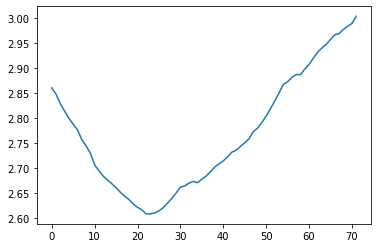

In [25]:
plt.plot(rmse['PredRNN']['v10'])